In [8]:
from ram import get_transform
from ram import inference_ram as inference
from ram.models import ram

from loguru import logger
import torch

/home/dnth/mambaforge-pypy3/envs/pt-to-edge-blog/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dnth/mambaforge-pypy3/envs/pt-to-edge-blog/lib/python3.11/site-packages/fairscale/experimental/nn/offload.py:19: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_fwd(orig_func)  # type: ignore
/home/dnth/mambaforge-pypy3/envs/pt-to-edge-blog/lib/python3.11/site-packages/fairscale/experimental/nn/offload.py:30: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  return torch.cuda.amp.custom_bwd(orig_func)  # type: ignore


In [9]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

transform = get_transform(image_size=384)
inference = inference

logger.info("Loading model...")
model_path = "ram_swin_large_14m.pth"

model = ram(
    pretrained=model_path,
    image_size=384,
    vit="swin_l",
)
model.eval()
model = model.to(device)

2024-09-05 11:55:46.570 | INFO     | __main__:<module>:7 - Loading model...


/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/output/LayerNorm is tied
/encoder/layer/0/intermediate/dense is tied
/encoder/layer/0/output/dense is tied
/encoder/layer/0/output/LayerNorm is tied
/encoder/layer/1/crossattention/self/query is tied
/encoder/layer/1/crossattention/self/key is tied
/encoder/layer/1/crossattention/self/value is tied
/encoder/layer/1/crossattention/output/dense is tied
/encoder/layer/1/crossattention/output/LayerNorm is tied
/encoder/layer/1/intermediate/dense is tied
/encoder/layer/1/output/dense is tied
/encoder/layer/1/output/LayerNorm is tied
--------------
ram_swin_large_14m.pth
--------------
load checkpoint from ram_swin_large_14m.pth
vit: swin_l


In [10]:
def custom_forward(self, x):
    label_embed = torch.nn.functional.relu(self.wordvec_proj(self.label_embed))

    image_embeds = self.image_proj(self.visual_encoder(x))
    image_atts = torch.ones(image_embeds.size()[:-1],
                            dtype=torch.long).to(x.device)

    image_cls_embeds = image_embeds[:, 0, :]
    image_spatial_embeds = image_embeds[:, 1:, :]

    bs = image_spatial_embeds.shape[0]
    label_embed = label_embed.unsqueeze(0).repeat(bs, 1, 1)
    tagging_embed = self.tagging_head(
        encoder_embeds=label_embed,
        encoder_hidden_states=image_embeds,
        encoder_attention_mask=image_atts,
        return_dict=False,
        mode='tagging',
    )

    logits = self.fc(tagging_embed[0]).squeeze(-1)

    targets = torch.where(
        torch.sigmoid(logits) > self.class_threshold.to(x.device),
        torch.tensor(1.0).to(x.device),
        torch.zeros(self.num_class).to(x.device))

    bs_tensor = torch.tensor([bs]).to(x.device)

    return (targets, bs_tensor)

# Store the original forward method
model.original_forward = model.forward

# Replace the forward method with our custom one
model.forward = custom_forward.__get__(model)

In [11]:
torch.onnx.export(model, 
                  torch.rand(1, 3, 384, 384, requires_grad=True), 
                  "ram.onnx",
                  export_params=True,        
                  opset_version=18,          
                  do_constant_folding=True,
                  input_names = ['input'],   
                  output_names = ['output'],)

In [12]:

import onnx

# Load the ONNX model
model = onnx.load("ram.onnx")

# Check that the model is well formed
onnx.checker.check_model(model)


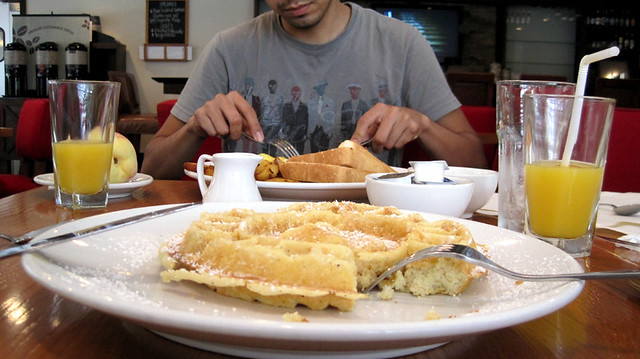

In [13]:
import requests
from PIL import Image
from io import BytesIO

# Download the image
response = requests.get("https://farm7.staticflickr.com/6175/6151904986_c859ef1f78_z.jpg")
image = Image.open(BytesIO(response.content))

image

In [ ]:
# save image
image.save("image_test_ram.jpg")

In [14]:
transform = get_transform(image_size=384)
transform

Compose(
    <function convert_to_rgb at 0x73d3f06ff060>
    Resize(size=(384, 384), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [15]:
import numpy as np
from PIL import Image

def transform_numpy(image):
    # Convert to RGB
    image = image.convert('RGB')
    
    # Resize
    image = image.resize((384, 384), Image.BILINEAR)
    
    # Convert to numpy array and normalize
    img_np = np.array(image).astype(np.float32) / 255.0
    
    # Transpose from (H, W, C) to (C, H, W)
    img_np = img_np.transpose(2, 0, 1)
    
    # Normalize
    mean = np.array([0.485, 0.456, 0.406]).reshape(-1, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(-1, 1, 1)
    img_np = (img_np - mean) / std

    img_np = img_np.astype(np.float32)
    
    return img_np

transform_numpy(image).shape


(3, 384, 384)

In [16]:
# run inference

import onnxruntime as ort

session = ort.InferenceSession("ram.onnx")
session.set_providers(["CPUExecutionProvider"])

input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

transformed_image = transform_numpy(image)
transformed_image = np.expand_dims(transformed_image, axis=0)


In [17]:
transformed_image.shape

(1, 3, 384, 384)

In [18]:
output = session.run([output_name], {input_name: transformed_image})
output

[array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)]

In [19]:
import numpy as np

def postprocess(output, tag_list, tag_list_chinese, delete_tag_index=None):
    tags = output[0] 
    
    if delete_tag_index is not None:
        tags[:, delete_tag_index] = 0
    
    tag_output = []
    tag_output_chinese = []
    
    for b in range(tags.shape[0]):
        index = np.argwhere(tags[b] == 1)
        token = np.array(tag_list)[index].squeeze(axis=1)
        tag_output.append(" | ".join(token))
        token_chinese = np.array(tag_list_chinese)[index].squeeze(axis=1)
        tag_output_chinese.append(" | ".join(token_chinese))
    
    return tag_output, tag_output_chinese

with open('ram_tag_list.txt', 'r') as f:
    tag_list = [line.strip() for line in f.readlines()]

with open('ram_tag_list_chinese.txt', 'r', encoding='utf-8') as f:
    tag_list_chinese = [line.strip() for line in f.readlines()]

processed_output, processed_output_chinese = postprocess(output, tag_list, tag_list_chinese)
print("English tags:", processed_output)
print("Chinese tags:", processed_output_chinese)

English tags: ['breakfast | bulletin board | butter | table | dinning table | plate | eat | food | fork | French toast | juice | man | omelet | orange juice | pancake | platter | sit | syrup | waffle']
Chinese tags: ['早餐 | 公告栏 | 黄油 | 桌子/表格 | 餐桌 | 盘子 | 吃 | 食物 | 餐叉 | 法式吐司 | 果汁 | 男人 | 煎蛋卷 | 橙汁 | 煎饼 | 大浅盘 | 坐/放置/坐落 | 糖浆 | 华夫饼干']


In [ ]:
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic
import onnx

def quantize_ram_model(input_model_path, output_model_path):
    # Check ONNX version
    onnx_version = tuple(map(int, onnx.__version__.split(".")))
    assert onnx_version >= (1, 14, 0), f"The onnx version must be greater than or equal to '1.14.0', but got {onnx_version}"
    
    print(f"Quantizing model and writing to {output_model_path}...")
    quantize_dynamic(
        model_input=input_model_path,
        model_output=output_model_path,
        per_channel=False,
        reduce_range=False,
        weight_type=QuantType.QUInt8,
    )
    print("Quantization complete.")


quantize_ram_model('ram.onnx', 'ram_quantized.onnx')


In [22]:
import onnxruntime as ort
import numpy as np
from PIL import Image
import requests
from io import BytesIO

import numpy as np

def transform_numpy(image):
    # Convert to RGB
    image = image.convert('RGB')
    
    # Resize
    image = image.resize((384, 384), Image.BILINEAR)
    
    # Convert to numpy array and normalize
    img_np = np.array(image).astype(np.float32) / 255.0
    
    # Transpose from (H, W, C) to (C, H, W)
    img_np = img_np.transpose(2, 0, 1)
    
    # Normalize
    mean = np.array([0.485, 0.456, 0.406]).reshape(-1, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(-1, 1, 1)
    img_np = (img_np - mean) / std

    img_np = img_np.astype(np.float32)
    
    return img_np

transform_numpy(image).shape

def postprocess(output, tag_list, tag_list_chinese, delete_tag_index=None):
    tags = output[0] 
    
    if delete_tag_index is not None:
        tags[:, delete_tag_index] = 0
    
    tag_output = []
    tag_output_chinese = []
    
    for b in range(tags.shape[0]):
        index = np.argwhere(tags[b] == 1)
        token = np.array(tag_list)[index].squeeze(axis=1)
        tag_output.append(" | ".join(token))
        token_chinese = np.array(tag_list_chinese)[index].squeeze(axis=1)
        tag_output_chinese.append(" | ".join(token_chinese))
    
    return tag_output, tag_output_chinese

# Load the quantized ONNX model
session = ort.InferenceSession('ram.onnx')

# Prepare the image (assuming we're using the same preprocessing as before)
response = requests.get("https://farm7.staticflickr.com/6175/6151904986_c859ef1f78_z.jpg")
image = Image.open(BytesIO(response.content)).convert('RGB')

input_tensor = transform_numpy(image)
input_tensor = np.expand_dims(input_tensor, axis=0)

# Run inference
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
output = session.run([output_name], {input_name: input_tensor})

# Post-process the output (using the previously defined function)
processed_output, processed_output_chinese = postprocess(output, tag_list, tag_list_chinese)

print("Quantized model inference results:")
print("English tags:", processed_output)
print("Chinese tags:", processed_output_chinese)


Quantized model inference results:
English tags: ['breakfast | bulletin board | butter | table | dinning table | plate | eat | food | fork | French toast | juice | man | omelet | orange juice | pancake | platter | sit | syrup | waffle']
Chinese tags: ['早餐 | 公告栏 | 黄油 | 桌子/表格 | 餐桌 | 盘子 | 吃 | 食物 | 餐叉 | 法式吐司 | 果汁 | 男人 | 煎蛋卷 | 橙汁 | 煎饼 | 大浅盘 | 坐/放置/坐落 | 糖浆 | 华夫饼干']
